
### Code originally written by neurotrader888, modified by this team. Original code can be found at the repository below, with a full citation in the study
https://github.com/neurotrader888/TrendLineAutomation/tree/main


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf 
import yfinance as yf

In [2]:
LOOKBACK = 30

In [4]:
"""
Compute sum of differences between line and prices, return negative val if invalid 

support : Upper or Lower trendline
pivot : Index of the pivot point
slope : Slope being tested
y : The data the slope is being calculated against

returns: Sum of differences between lines and prices. This is used to measure the deviation from the mean
"""
# TODO: I feel like we can calculate the difference using a single line of code here vs calling an entire function to do it
def check_trend_line(support: bool, pivot: int, slope: float, y: np.array):

    # Find the intercept of the line going through pivot point with given slope

    intercept = -slope * pivot + y[pivot]
    line_vals = slope * np.arange(len(y)) + intercept
    
    diffs = line_vals - y
    
    # Check to see if the line is valid, return -1 if it is not valid.
    if support and diffs.max() > 1e-5:
        return -1.0
    elif not support and diffs.min() < -1e-5:
        return -1.0

    # Squared sum of diffs between data and line. This is what we will be minimizing
    # TODO: Is there a way to optimize this process? This may be inaccurate
    err = (diffs ** 2.0).sum()
    
    return err

In [5]:
"""
Minimizes sum of squared differences using gradient descent

support : Upper or Lower trendline
pivot : Index of the pivot point
init_slope : Unitial slope value for the line of best fit
y : The data we are testing against
"""
# TODO: Implement gradient descent

def optimize_slope(support: bool, pivot:int , init_slope: float, y: np.array):
    
    # Amount to change slope by. Multiplyed by opt_step
    slope_unit = (y.max() - y.min()) / len(y) 
    
    # Optmization variables
    opt_step = 1.0
    min_step = 0.0001
    curr_step = opt_step # current step
    
    # Initiate at the slope of the line of best fit
    best_slope = init_slope
    best_err = check_trend_line(support, pivot, init_slope, y)
    assert(best_err >= 0.0) # Shouldn't ever fail with initial slope

    # TODO: Optimize this process
    get_derivative = True
    derivative = None
    # Run until the step size reaches the minimum value
    while curr_step > min_step:

        # Find the derivative
        if get_derivative:
            # Numerical differentiation, increase slope by very small amount
            # to see if error increases/decreases. 
            # Gives us the direction to change slope.
            slope_change = best_slope + slope_unit * min_step
            test_err = check_trend_line(support, pivot, slope_change, y)
            derivative = test_err - best_err
            
            # If increasing by a small amount fails, 
            # try decreasing by a small amount
            if test_err < 0.0:
                slope_change = best_slope - slope_unit * min_step
                test_err = check_trend_line(support, pivot, slope_change, y)
                derivative = best_err - test_err

            if test_err < 0.0: # Derivative failed, give up
                raise Exception("Derivative failed. Check your data. ")

            get_derivative = False

        # Test to see if the error goes up or down. Change the test slope by the current step 
        if derivative > 0.0: # Increasing slope increased error
            test_slope = best_slope - slope_unit * curr_step
        else: # Increasing slope decreased error
            test_slope = best_slope + slope_unit * curr_step
        
        # get the error
        test_err = check_trend_line(support, pivot, test_slope, y)
        if test_err < 0 or test_err >= best_err: 
            # slope failed/didn't reduce error
            curr_step *= 0.5 # Reduce step size
        else: # test slope reduced error
            best_err = test_err 
            best_slope = test_slope
            get_derivative = True # Recompute derivative
    
    # Optimize done, return best slope and intercept
    return best_slope, -best_slope * pivot + y[pivot]


In [8]:
def fit_trendlines_single(data: np.array):
    # find line of best fit (least squared) 
    # coefs[0] = slope,  coefs[1] = intercept 
    
    # Get the slope and intercept using polyfit
    x = np.arange(len(data))
    coefs = np.polyfit(x, data, 1)

    # Get value off the line at each point in the array
    line_points = coefs[0] * x + coefs[1]

    # Find upper and lower pivot points
    upper_pivot = (data - line_points).argmax() 
    lower_pivot = (data - line_points).argmin() 
   
    # Optimize the slope for both trend lines
    support_coefs = optimize_slope(True, lower_pivot, coefs[0], data)
    resist_coefs = optimize_slope(False, upper_pivot, coefs[0], data)

    return support_coefs, resist_coefs

In [9]:
def fit_trendlines_high_low(high: np.array, low: np.array, close: np.array):
    x = np.arange(len(close))
    coefs = np.polyfit(x, close, 1)
    # coefs[0] = slope,  coefs[1] = intercept
    line_points = coefs[0] * x + coefs[1]
    upper_pivot = (high - line_points).argmax() 
    lower_pivot = (low - line_points).argmin() 
    
    support_coefs = optimize_slope(True, lower_pivot, coefs[0], low)
    resist_coefs = optimize_slope(False, upper_pivot, coefs[0], high)

    return support_coefs, resist_coefs

In [4]:
# Trendline parameter
lookback = LOOKBACK

data = yf.download('AAPL', start="2020-01-01", end="2021-01-01")
data.rename(columns={'Adj Close': 'Adj_Close'}, inplace=True)

# Add adj high and low, which may be important later
data['Adj_High'] = data['Adj_Close'] * data['High'] / data['Close']
data['Adj_Low'] = data['Adj_Close'] * data['Low'] / data['Close']

data.columns = [x.lower() for x in data.columns]
data = np.log(data)
data.head()

[*********************100%***********************]  1 of 1 completed


,open,high,low,close,adj_close,volume,adj_high,adj_low
Date,,,,,,,,
2020-01-02,4.304876,4.319486,4.301325,4.318654,4.291273,18.724338,4.292105,4.273944
2020-01-03,4.307943,4.319420,4.305753,4.308885,4.281503,18.801326,4.292038,4.278372
2020-01-06,4.296571,4.317355,4.293025,4.316821,4.289440,18.589471,4.289974,4.265644
2020-01-07,4.316955,4.320484,4.309053,4.312107,4.284726,18.505683,4.293103,4.281672
2020-01-08,4.307976,4.332180,4.307976,4.328065,4.300684,18.698912,4.304799,4.280595


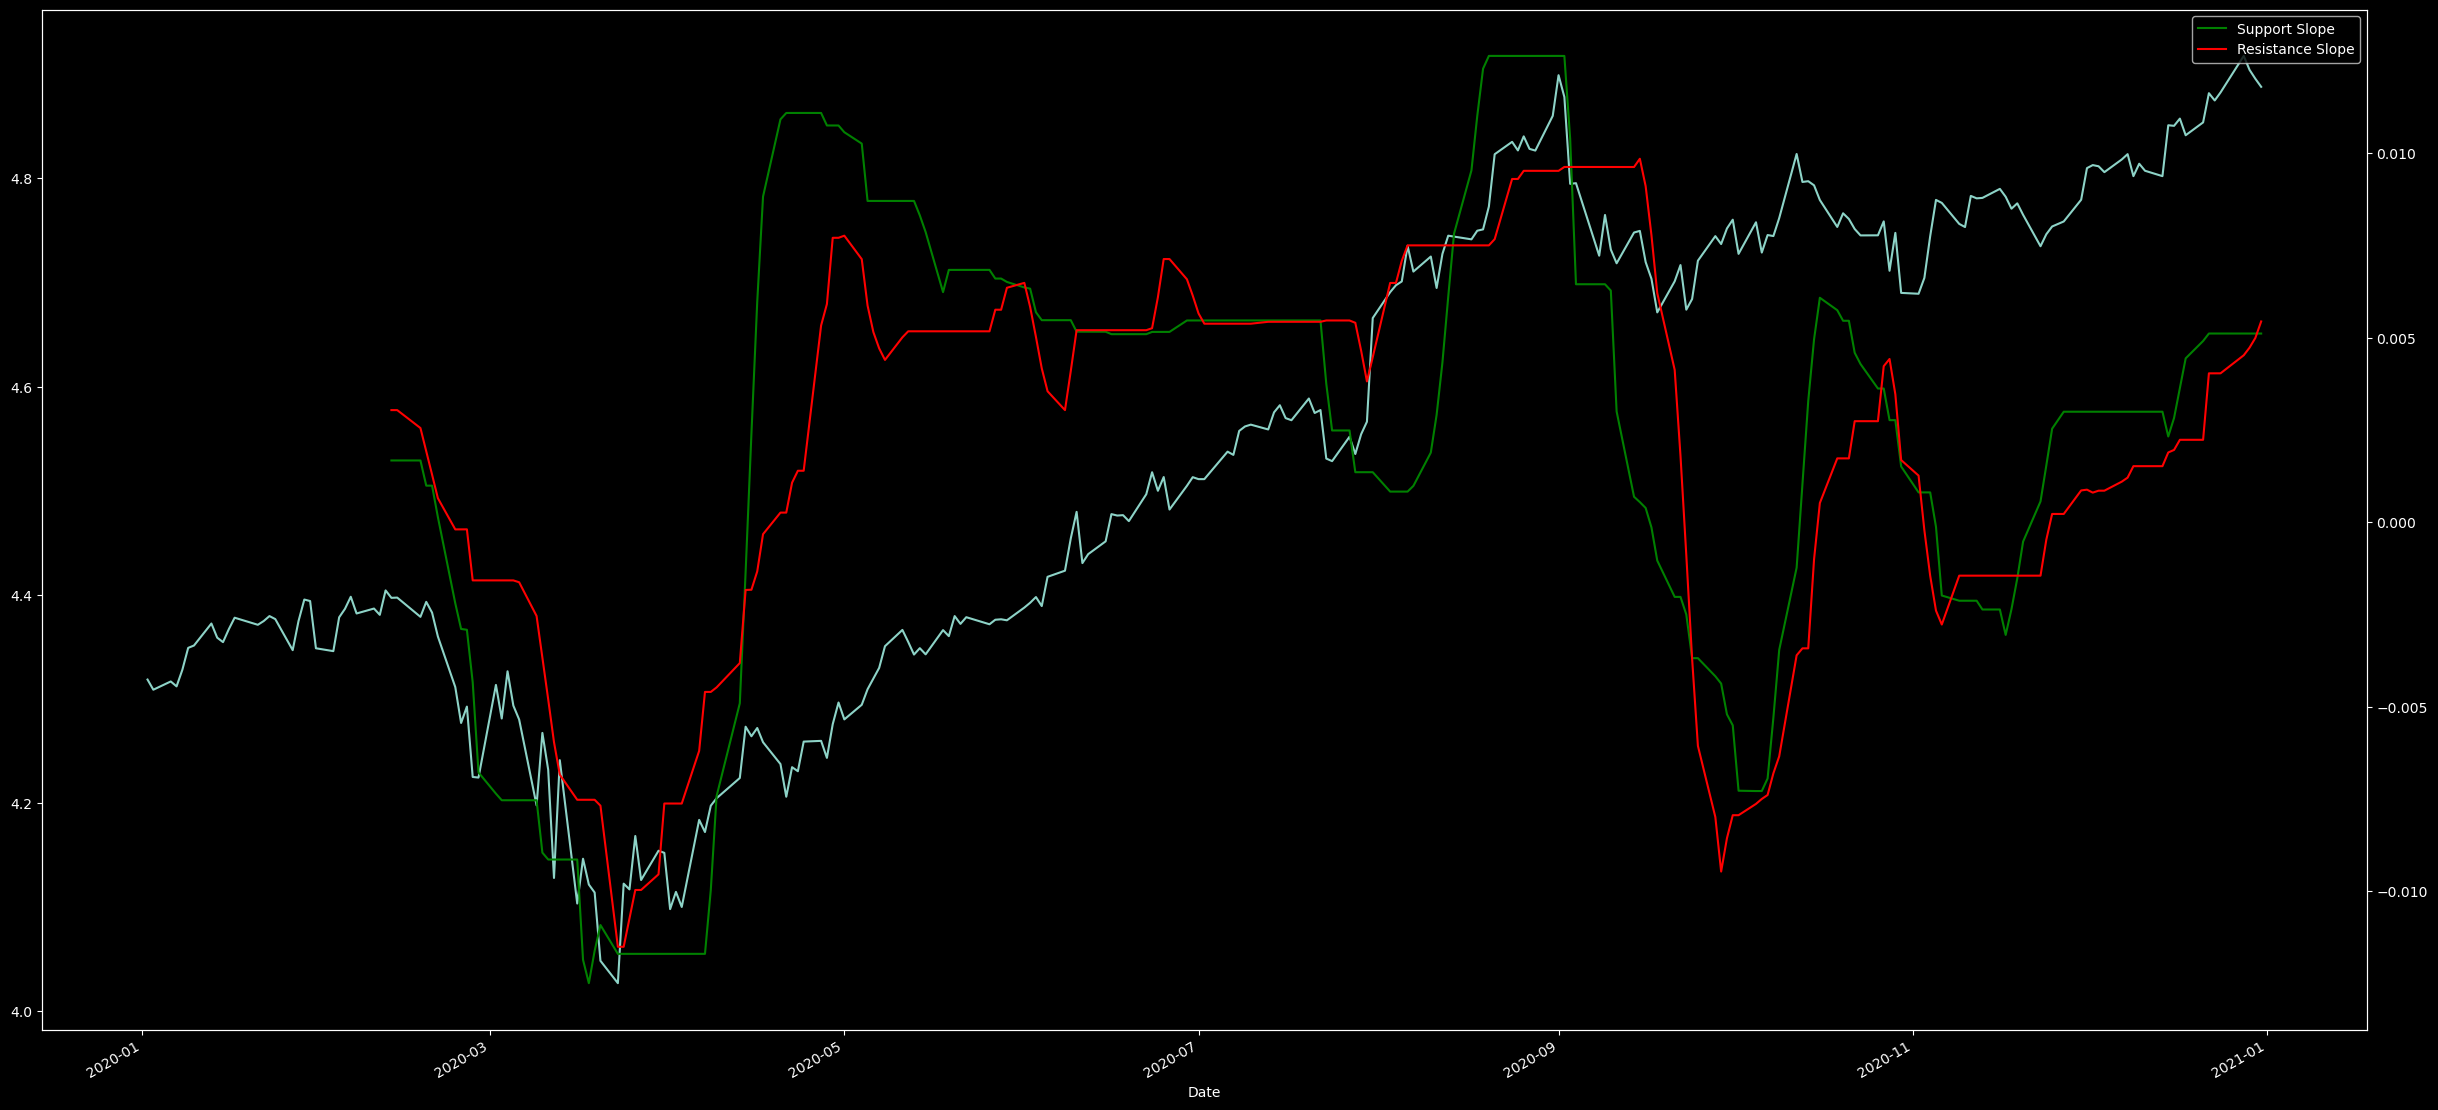

In [11]:
support_slope = [np.nan] * len(data)
resist_slope = [np.nan] * len(data)
for i in range(lookback - 1, len(data)):
    candles = data.iloc[i - lookback + 1: i + 1]
    support_coefs, resist_coefs =  fit_trendlines_high_low(candles['high'], 
                                                           candles['low'], 
                                                           candles['close'])
    support_slope[i] = support_coefs[0]
    resist_slope[i] = resist_coefs[0]

data['support_slope'] = support_slope
data['resist_slope'] = resist_slope

plt.style.use('dark_background')
fig, ax1 = plt.subplots(figsize=(30,15))
ax2 = ax1.twinx()
data['close'].plot(ax=ax1)
data['support_slope'].plot(ax=ax2, label='Support Slope', color='green')
data['resist_slope'].plot(ax=ax2, label='Resistance Slope', color='red')
plt.legend()
plt.show()

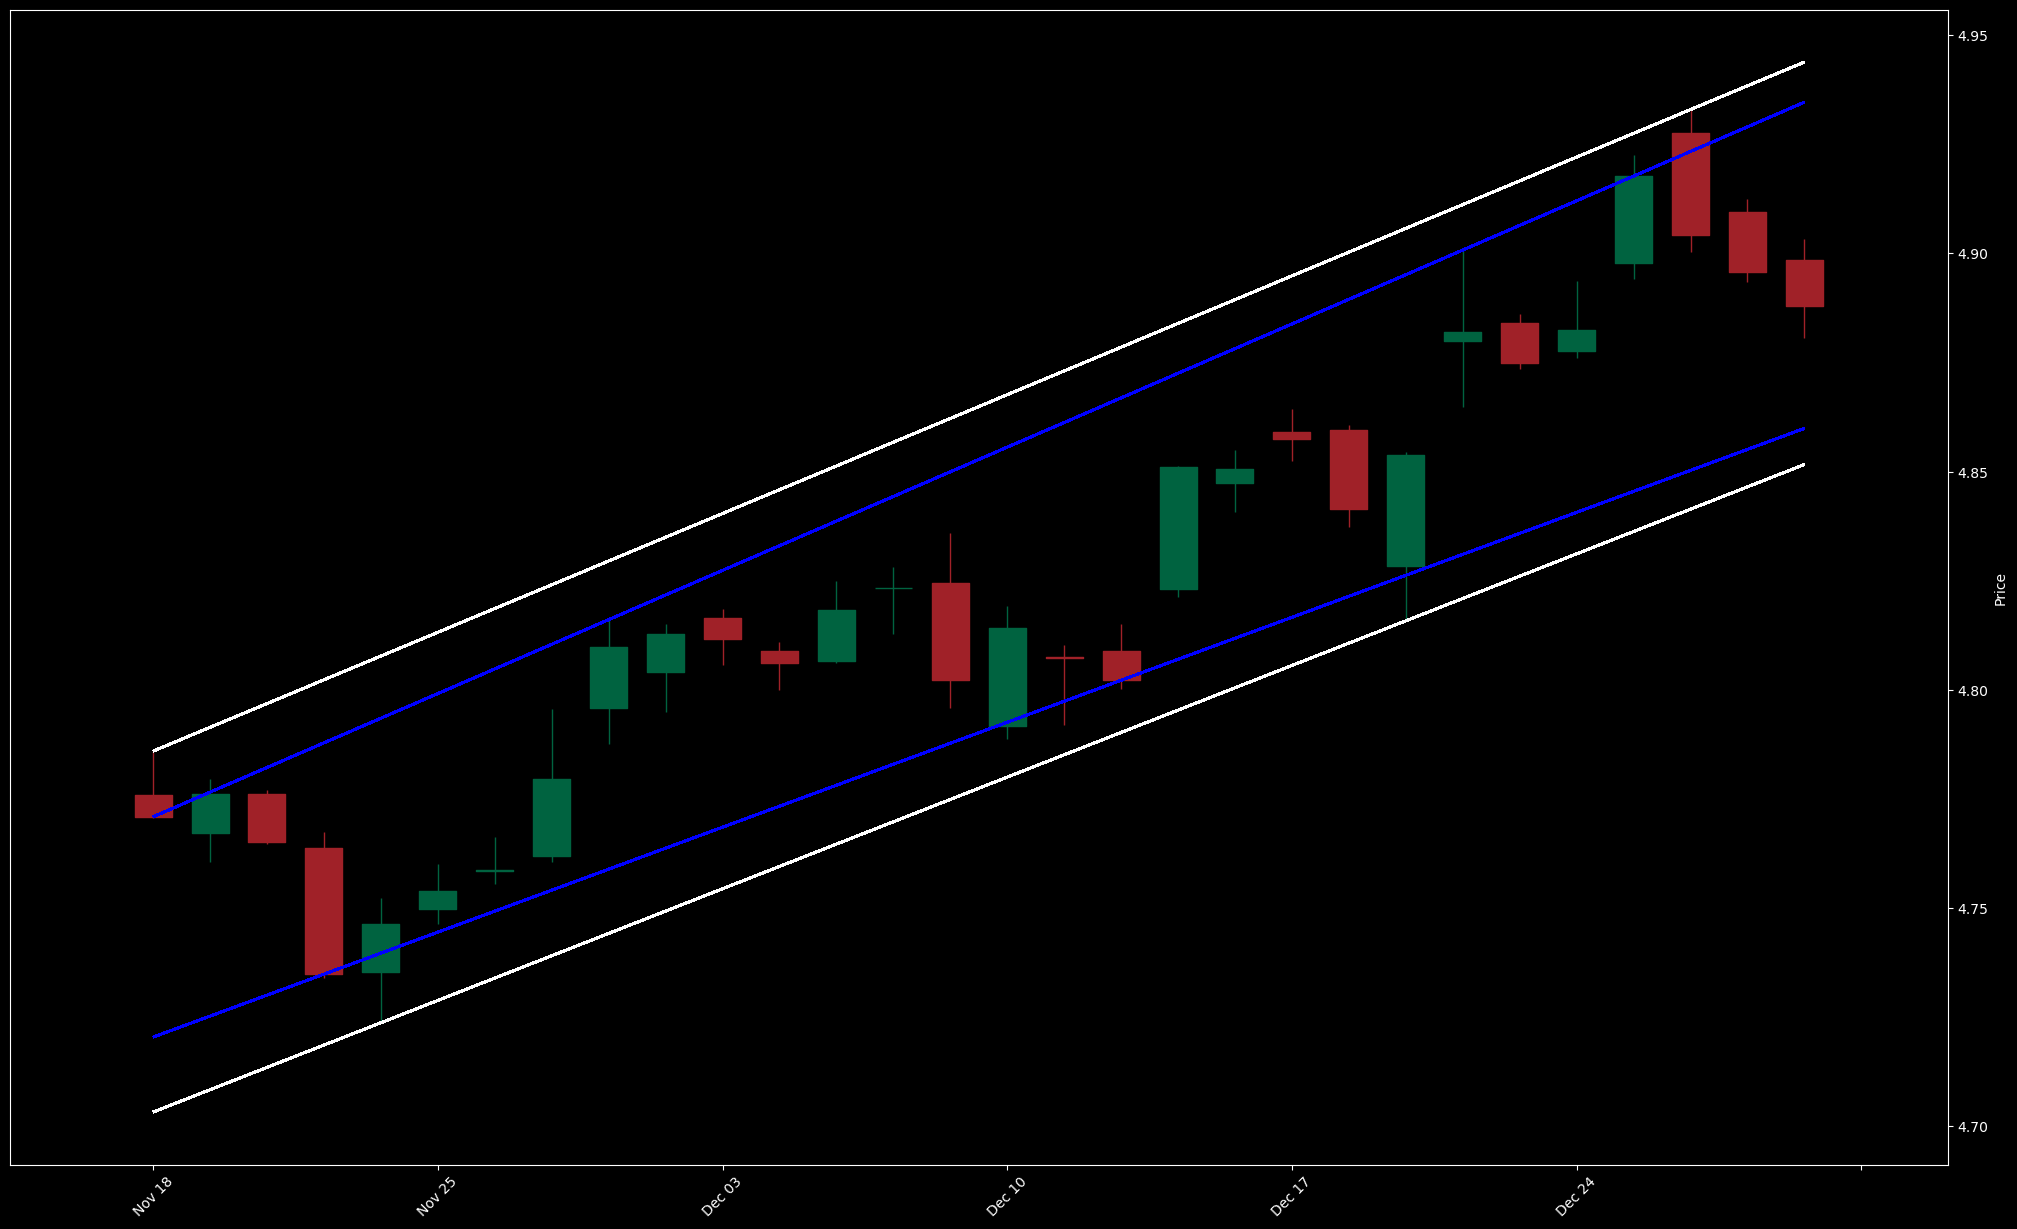

In [12]:
candles = data.iloc[-30:] # Last 30 candles in data
support_coefs_c, resist_coefs_c = fit_trendlines_single(candles['close'])
support_coefs, resist_coefs = fit_trendlines_high_low(candles['high'], candles['low'], candles['close'])

support_line_c = support_coefs_c[0] * np.arange(len(candles)) + support_coefs_c[1]
resist_line_c = resist_coefs_c[0] * np.arange(len(candles)) + resist_coefs_c[1]

support_line = support_coefs[0] * np.arange(len(candles)) + support_coefs[1]
resist_line = resist_coefs[0] * np.arange(len(candles)) + resist_coefs[1]

plt.subplots(figsize=(25,15))
ax = plt.gca()

def get_line_points(candles, line_points):
    # Place line points in tuples for matplotlib finance
    # https://github.com/matplotlib/mplfinance/blob/master/examples/using_lines.ipynb
    idx = candles.index
    line_i = len(candles) - len(line_points)
    assert(line_i >= 0)
    points = []
    for i in range(line_i, len(candles)):
        points.append((idx[i], line_points[i - line_i]))
    return points

s_seq = get_line_points(candles, support_line)
r_seq = get_line_points(candles, resist_line)
s_seq2 = get_line_points(candles, support_line_c)
r_seq2 = get_line_points(candles, resist_line_c)
mpf.plot(candles, alines=dict(alines=[s_seq, r_seq, s_seq2, r_seq2], colors=['w', 'w', 'b', 'b']), type='candle', style='charles', ax=ax)
plt.show()